# **Facial Expression Recognition**

Model for predicting human facial expression with the help of CNN, dataset is picked up from __[Kaggle](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge)__ accruarcy is not reasonable but there are still scope for improvements. feel free to tweak and test the model fot your self. 

In [1]:
# Libraries

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Input,Conv2D,MaxPooling2D,Flatten,Dropout,BatchNormalization,Dense
from keras.preprocessing.image import ImageDataGenerator as Imgen
from keras.callbacks import EarlyStopping,ModelCheckpoint

from sklearn.metrics import confusion_matrix,classification_report

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## **Reading and Organiing Data**

In [3]:
# reading the data
data = pd.read_csv("/content/gdrive/MyDrive/FacialRecognitionDataset/icml_face_data.csv")
data.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [4]:
cols = ["emotion","subset","pixels"]
data.columns = cols
data.columns

Index(['emotion', 'subset', 'pixels'], dtype='object')

In [5]:
emotions = ['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']

In [6]:
print(data.subset.value_counts())
print(data.emotion.value_counts())

Training       28709
PublicTest      3589
PrivateTest     3589
Name: subset, dtype: int64
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64


In [7]:
# Splitting into train test and validate

train_data = data[data["subset"]=="Training"]
val_data = data[data["subset"]=="PublicTest"]
test_data = data[data["subset"]=="PrivateTest"]

print(train_data.shape,test_data.shape,val_data.shape)

(28709, 3) (3589, 3) (3589, 3)


In [8]:
# to extract image data from pixel column

def toPixels(pixels):

    arr = np.array(pixels.split(),"float64")
    return arr

def reshapetoImage(data):

    Images = np.reshape(data["pixels"].to_list(),(data.shape[0],48,48,1))

    return Images

In [9]:
train_data["pixels"] = train_data["pixels"].apply(toPixels)
val_data["pixels"] = val_data["pixels"].apply(toPixels)
test_data["pixels"] = test_data["pixels"].apply(toPixels)

In [10]:
# images and labels

train_images = reshapetoImage(train_data)
val_images = reshapetoImage(val_data)
test_images = reshapetoImage(test_data)

train_labels = train_data["emotion"]
val_labels = val_data["emotion"]
test_labels = test_data["emotion"]

### **Visualaizing some Images**

In [11]:
def plotImages(x,y):
    plt.figure(figsize=[20,12])
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.imshow(x[i],cmap="gray")
        plt.title(emotions[y[i]])
        plt.axis("off")
    plt.show()

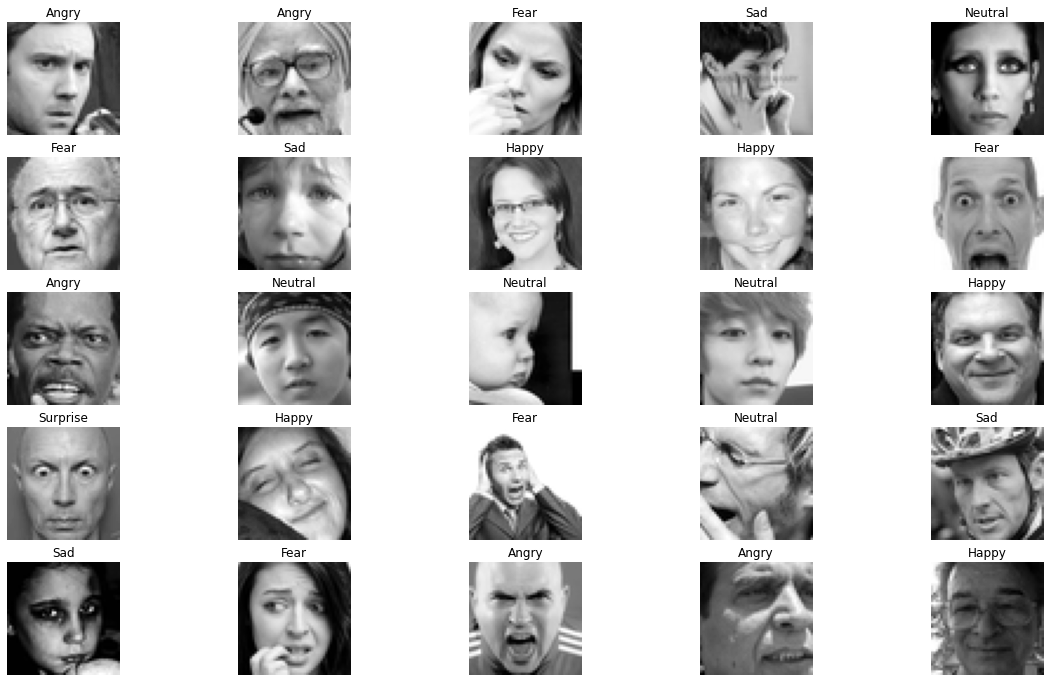

In [13]:
plotImages(tf.squeeze(train_images),tf.squeeze(train_labels))

## **Image Data Generator**

In [14]:
trainGen = Imgen(rescale=1./255,
                 zoom_range=0.2,
                 shear_range=0.2,
                 horizontal_flip=True
                 )
valGen = Imgen(rescale=1./255,
                 zoom_range=0.2,
                 shear_range=0.2,
                 horizontal_flip=True
               )
testGen = Imgen(rescale=1./255)

In [15]:
trainds = trainGen.flow(train_images,train_labels,
                   batch_size = 32
                   )

valds = valGen.flow(val_images,val_labels,
               batch_size = 32
               )

testds = testGen.flow(test_images,test_labels,
                      batch_size=32,
                      shuffle=False)

**One batch**

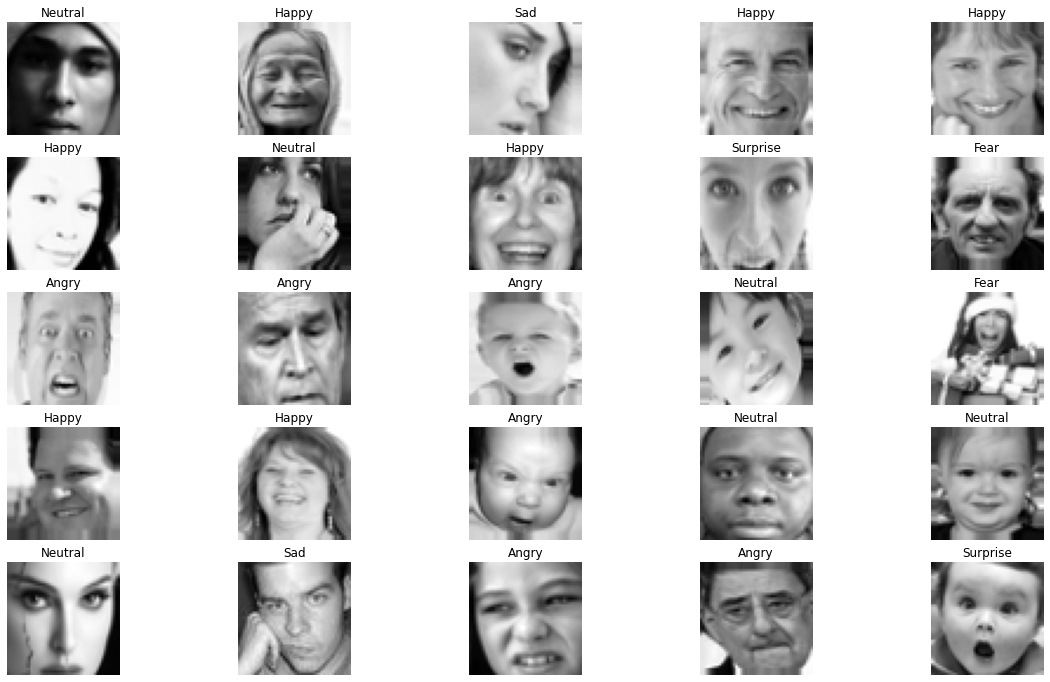

In [17]:
# one batch
x,y = next(trainds)

# see 
plotImages(tf.squeeze(x),tf.squeeze(y))

## **Model**

In [18]:
# Model
image_input = Input(shape=(48,48,1))

x = Conv2D(64,(3,3), activation="relu")(image_input)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)
x = Dropout(0.3)(x)

x = Conv2D(128,(3,3),activation="relu")(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)
x = Dropout(0.3)(x)

x = Conv2D(512,(3,3),activation="relu")(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)
x = Dropout(0.3)(x)

x = Conv2D(512,(3,3),activation="relu")(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)
x = Dropout(0.3)(x)

x = Flatten()(x)

x = Dense(512,activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(256,activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

image_output = Dense(7,activation="softmax")(x)

model = Model(image_input,image_output)

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 46, 46, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 23, 23, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 128)       73856 

In [36]:
# Compile the model
print("Compiling the Model....")
model.compile(optimizer='adam',loss = 'sparse_categorical_crossentropy', metrics=["accuracy"])
print("Model Compiled!")

Compiling the Model....
Model Compiled!


In [37]:
# Defining callbacks
my_calls = [EarlyStopping(monitor='val_accuracy',patience=5),
            ModelCheckpoint("Model_ethnicity.h5",verbose=1,save_best_only=True)]

**Train**

In [ ]:
hist = model.fit(trainds, epochs=40, validation_data=valds, callbacks=my_calls)

Epoch 1/40
537/898 [================>.............] - ETA: 5:25 - loss: 2.2727 - accuracy: 0.2017

**Test**

In [ ]:
model.evaluate(testds)

**Graph**

In [ ]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.plot(hist.epoch,hist.history['accuracy'],label = 'Training')
plt.plot(hist.epoch,hist.history['val_accuracy'],label = 'validation')

plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist.epoch,hist.history['loss'],label = 'Training')
plt.plot(hist.epoch,hist.history['val_loss'],label = 'validation')

plt.title("Loss")
plt.legend()
plt.show()


## **Predictions**

In [ ]:
pred = model.predict(testds)

In [ ]:
pred = [np.argmax(i) for i in pred]

In [ ]:
y_test = np.array(test_labels)

In [ ]:
print(classification_report(y_test,pred))

In [ ]:
plt.figure(figsize=[20,14])
sns.heatmap(confusion_matrix(y_test,pred),annot = True, fmt= "d", cmap = "Blues");